<a href="https://colab.research.google.com/github/FleaBusyBeeBergs/dtsa5511-rnn/blob/main/nlp_disaster_tweets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Week 4: Natural Disaster Tweets - RNN model

DTSA 5511 - Intro to Deep Learning

## 1. Introduction

###1.1 Description of the problem
The purpose of this project is to classify tweets as either a true natural disaster or not true natural disaster using a Recurrent Neural Network (RNN). RNNs are useful for sequential datasets, such as natural language processing. In natural language, the order in which words appear may change the meaning of the sentence. RNNs take this sequence into consideration by making a backwards pass over the data to update the model weights.

In [1]:
# !pip install imbalanced-learn

In [2]:
# general utilities
import os
import pandas as pd
from google.colab import files
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.utils import class_weight

from imblearn.over_sampling import SMOTE

import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.backend import clear_session
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [3]:
import re
import nltk

from nltk.corpus import stopwords
#from nltk.stem.porter import PorterStemmer
#import string
from sklearn.feature_extraction.text import TfidfVectorizer

In [4]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [5]:
!wget --no-check-certificate http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip
!ls glove.6B.100d.txt

--2025-06-16 16:55:43--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2025-06-16 16:55:44--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2025-06-16 16:55:44--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
  Issued certificate has expired.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zi

##2. EDA and cleaning

###2.1 The data

In [6]:
# get set up with kaggle
files.upload()
!pip install -q kaggle
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
# note to self: kaggle file is in dtsa5511 folder

Saving kaggle.json to kaggle.json


In [7]:
!kaggle competitions download -c nlp-getting-started -p /content/data > /dev/null
!unzip /content/data/nlp-getting-started -d ./data > /dev/null

100% 593k/593k [00:00<00:00, 792MB/s]


In [8]:
df_train = pd.read_csv('./data/train.csv')
df_test = pd.read_csv('./data/test.csv')

### 2.2 EDA & Cleaning

In [9]:
df_train.describe()

,id,target
count,7613.000000,7613.00000
mean,5441.934848,0.42966
std,3137.116090,0.49506
min,1.000000,0.00000
25%,2734.000000,0.00000
50%,5408.000000,0.00000
75%,8146.000000,1.00000
max,10873.000000,1.00000


In [10]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


The training dataset contains a little over 7,600 tweets, all with labels. The columns included are:
Numerical - id and target (bool)
Text objects - keyword, location, and text.
The data uses 297.5+ KB memory.
There are 61 records that are missing a keyword, and 2533 records missing a location. I'll add the keyword into the text column.

In [11]:
df_train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [33]:
#df_train.loc[0:31,]

In [32]:
# add keyword into text column
df_train['keyword'] = df_train['keyword'].fillna('')
df_train['combined_text'] = df_train['keyword'] + ' ' + df_train['text']

In [20]:
df_train.head()

,id,keyword,location,text,target,combined_text
0,1,,NaN,Our Deeds are the Reason of this #earthquake M...,1,Our Deeds are the Reason of this #earthquake ...
1,4,,NaN,Forest fire near La Ronge Sask. Canada,1,Forest fire near La Ronge Sask. Canada
2,5,,NaN,All residents asked to 'shelter in place' are ...,1,All residents asked to 'shelter in place' are...
3,6,,NaN,"13,000 people receive #wildfires evacuation or...",1,"13,000 people receive #wildfires evacuation o..."
4,7,,NaN,Just got sent this photo from Ruby #Alaska as ...,1,Just got sent this photo from Ruby #Alaska as...


In [21]:
df_train = df_train.drop(columns = 'text')

In [22]:
df_train.rename(columns = {'combined_text': 'text'}, inplace = True)

In [23]:
df_train.head()

,id,keyword,location,target,text
0,1,,NaN,1,Our Deeds are the Reason of this #earthquake ...
1,4,,NaN,1,Forest fire near La Ronge Sask. Canada
2,5,,NaN,1,All residents asked to 'shelter in place' are...
3,6,,NaN,1,"13,000 people receive #wildfires evacuation o..."
4,7,,NaN,1,Just got sent this photo from Ruby #Alaska as...


In [24]:
df_train['keyword'].unique()


array(['', 'ablaze', 'accident', 'aftershock', 'airplane%20accident',
       'ambulance', 'annihilated', 'annihilation', 'apocalypse',
       'armageddon', 'army', 'arson', 'arsonist', 'attack', 'attacked',
       'avalanche', 'battle', 'bioterror', 'bioterrorism', 'blaze',
       'blazing', 'bleeding', 'blew%20up', 'blight', 'blizzard', 'blood',
       'bloody', 'blown%20up', 'body%20bag', 'body%20bagging',
       'body%20bags', 'bomb', 'bombed', 'bombing', 'bridge%20collapse',
       'buildings%20burning', 'buildings%20on%20fire', 'burned',
       'burning', 'burning%20buildings', 'bush%20fires', 'casualties',
       'casualty', 'catastrophe', 'catastrophic', 'chemical%20emergency',
       'cliff%20fall', 'collapse', 'collapsed', 'collide', 'collided',
       'collision', 'crash', 'crashed', 'crush', 'crushed', 'curfew',
       'cyclone', 'damage', 'danger', 'dead', 'death', 'deaths', 'debris',
       'deluge', 'deluged', 'demolish', 'demolished', 'demolition',
       'derail', 'dera

###2.3 Visualization

target
0    0.57034
1    0.42966
Name: count, dtype: float64 



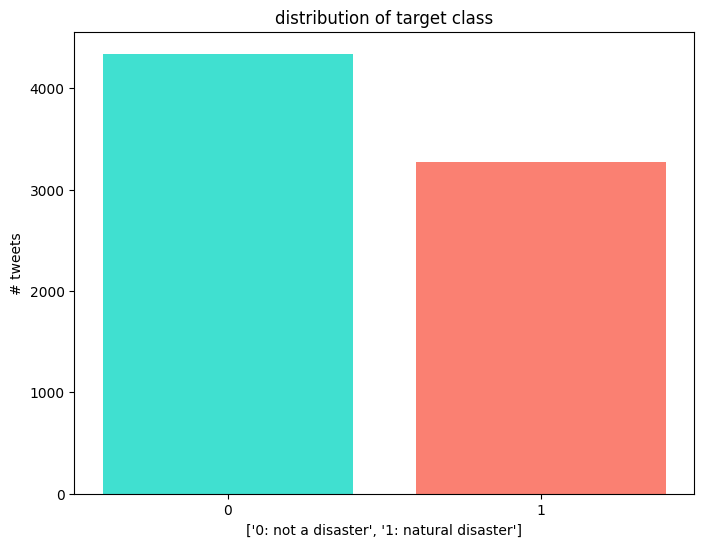

In [53]:
category_counts = df_train['target'].value_counts()
category_prop = category_counts / category_counts.sum()
print(category_prop, '\n')

# vis distribution
plt.figure(figsize = (8, 6))
plt.bar(category_counts.index,
        category_counts.values,
        color = ['turquoise', 'salmon'])
plt.xticks([0, 1])
plt.title('distribution of target class')
plt.xlabel(['0: not a disaster', '1: natural disaster'])
plt.ylabel('# tweets')
plt.show()

The classes are a little imbalanced. This will need to be dealt with for modelling.

### 2.4 Preprocessing data

In [26]:
# split data
X = df_train['text']
y = df_train['target']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, random_state = 5511)

In [28]:
# define functions to tokenize / embed text

class TextPreprocessor:
    def __init__(self):
        self.stop_words = set(stopwords.words('english'))

    def clean_text(self, text):
        text = text.lower()
        text = re.sub(r'http\S+|www\S+', '', text)
        text = re.sub(r'[^a-z\s]', '', text)
        text = re.sub(r'\s+', ' ', text).strip()
        return text

    def preprocess_tweet(self, text):
        words = text.split()
        words = [word for word in words if word not in self.stop_words]
        return ' '.join(words)

    def load_glove_embeddings(self, glove_path = 'glove.6B.100d.text'):
        embeddings_index = {}
        try:
            with open(glove_path, 'r', encoding = 'utf-8') as f:
                for line in f:
                    values = line.split()
                    word = values[0]
                    vector = np.asarray(values[1:], dtype = 'float32')
                    embeddings_index[word] = vector
        except FileNotFoundError:
            print(f'glove file not found at {glove_path}.Please check file is in correct location')
            return None
        return embeddings_index

    def get_embedding_matrix(self, tokenizer, embedding_dim = 100, glove_path = 'glove.6B.100d.txt'):
        embeddings_index = self.load_glove_embeddings(glove_path)
        if embeddings_index is None:
            return None

        vocab_size = len(tokenizer.word_index) + 1
        embedding_matrix = np.zeros((vocab_size, embedding_dim))

        for word, i in tokenizer.word_index.items():
            embedding_vector = embeddings_index.get(word)
            if embedding_vector is not None:
                embedding_matrix[i] = embedding_vector
        return embedding_matrix



In [34]:
# tokenize, preprocess

preprocessor = TextPreprocessor()

tokenizer = Tokenizer(num_words = 10000)
tokenizer.fit_on_texts(df_train['text'])

In [35]:
df_train['text'] = df_train['text'].apply(preprocessor.clean_text)
df_test['text'] = df_test['text'].apply(preprocessor.clean_text)

df_train['text'] = df_train['text'].apply(preprocessor.preprocess_tweet)
df_test['text'] = df_test['text'].apply(preprocessor.preprocess_tweet)

embedding_matrix = preprocessor.get_embedding_matrix(tokenizer)

In [40]:
# max seq lenght
max_seq_len = max([len(text.split()) for text in X_train])

In [42]:
# pad
X_train_sequences = tokenizer.texts_to_sequences(X_train)
X_val_sequences = tokenizer.texts_to_sequences(X_val)

X_train_padded = pad_sequences(X_train_sequences,
                               maxlen = max_seq_len,
                               padding = 'post',
                               truncating = 'post')
X_val_padded = pad_sequences(X_val_sequences,
                             maxlen = max_seq_len,
                             padding = 'post',
                             truncating = 'post')

Lets see what the top 10 words are for each target category.

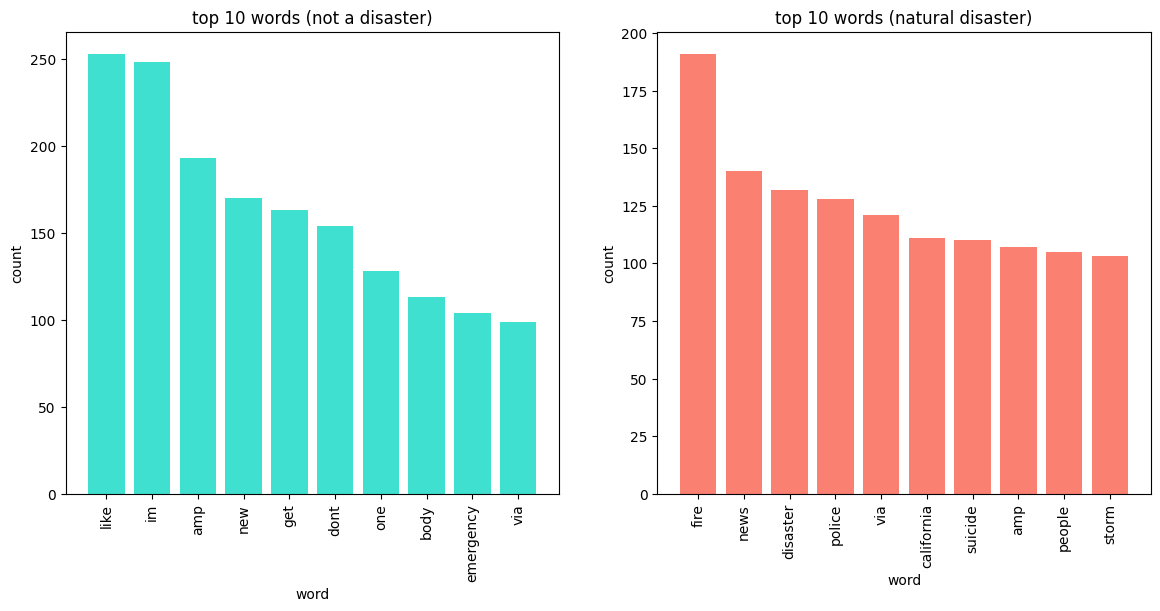

In [54]:
# top 10 words by category
word_count0 = pd.Series(' '.join(df_train[df_train['target'] == 0]['text']).split()).value_counts()
word_count1 = pd.Series(' '.join(df_train[df_train['target'] == 1]['text']).split()).value_counts()

#top 10
top0 = word_count0.head(10)
top1 = word_count1.head(10)

# plot
plt.figure(figsize = (14, 6))

plt.subplot(1, 2, 1)
plt.bar(x = top0.index,
        height = top0.values,
         color = 'turquoise')
plt.title('top 10 words (not a disaster)')
plt.xlabel('word')
plt.ylabel('count')
plt.gca().tick_params(axis = 'x', rotation = 90)

plt.subplot(1, 2, 2)
plt.bar(x = top1.index,
        height = top1.values,
        color = 'salmon')
plt.title('top 10 words (natural disaster)')
plt.xlabel('word')
plt.ylabel('count')
plt.gca().tick_params(axis = 'x', rotation = 90)
plt.show()

In [56]:
# dealing with imbalanced classes
class_weights = class_weight.compute_class_weight(
    class_weight = 'balanced',
    classes = np.unique(y_train),
    y = y_train
)

class_weights = dict(enumerate(class_weights))

## 3. Modelling

In [ ]:
embedding_layer = tf.keras.layers.Embedding(
    input_dim = embedding_matrix.shape[0],
    output_dim = embedding_matrix.shape[1],
    weights = [embedding_matrix],
    input_length = max_sequence_length,
    trainable = False
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


### 3.1 Vanilla RNN architecture

I'll start with a very basic rnn architecture:
* First layer: GloVe embedding layer, uses integer sequences representing the tweet and maps it to a dense vector representation.
* Second layer: LSTM layer with 64 neurons
* Third layer: Fully connected layer using the sigmoid activation function and single output for bianry classification

In [ ]:
# model1 - vanilla
model1 = tf.keras.Sequential([
    embedding_layer,
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(1, activation = 'sigmoid')
])

In [ ]:
# model1 compile
model1.compile(optimizer = 'adam',
              loss = 'binary_crossentropy',
              metrics = ['accuracy'])

In [ ]:
# model1 fit
clear_session()

early_stopping = EarlyStopping(monitor = 'val_loss',
                               patience = 3)

history = model1.fit(X_train_padded,
                     y_train,
                     epochs = 10,
                     validation_data = (X_val_padded, y_val),
                     verbose = 0,
                     callbacks  = [early_stopping])

In [ ]:
history1 = pd.DataFrame(history.history)
history1.head()

,accuracy,loss,val_accuracy,val_loss
0,0.773235,0.503422,0.775443,0.480978
1,0.804269,0.440152,0.808273,0.446273
2,0.812808,0.422727,0.810243,0.440554
3,0.816749,0.404154,0.816152,0.432845
4,0.828900,0.389632,0.822062,0.437843


In [ ]:
# add another layer

model2 = tf.keras.Sequential([
    embedding_layer,
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.LSTM(32),
    tf.keras.layers.Dense(1, activation='sigmoid')
])


In [ ]:
model2.compile(optimizer = 'adam',
               loss = 'binary_crossentropy',
               metrics = ['accuracy'])

In [ ]:
# model2 fit
clear_session()

early_stopping = EarlyStopping(monitor = 'val_loss',
                               patience = 3)


history2 = model2.fit(X_train_padded,
                     y_train,
                     epochs = 10,
                     validation_data = (X_val_padded, y_val),
                     verbose = 0,
                     callbacks  = [early_stopping])

In [ ]:
history2 = pd.DataFrame(history2.history)
history2

,accuracy,loss,val_accuracy,val_loss
0,0.957635,0.119330,0.774130,0.743178
1,0.965353,0.092025,0.760341,0.814823
2,0.969787,0.072423,0.764281,1.004704
3,0.976355,0.058126,0.772817,1.032588


In [ ]:
# bidirectional layer
model3 = tf.keras.Sequential([
    embedding_layer,
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [ ]:
model3.compile(optimizer = 'adam',
               loss = 'binary_crossentropy',
               metrics = ['accuracy'])

In [ ]:
# model3 fit
clear_session()

early_stopping = EarlyStopping(monitor = 'val_loss',
                               patience = 3)


history3 = model3.fit(X_train_padded,
                     y_train,
                     epochs = 10,
                     validation_data = (X_val_padded, y_val),
                     verbose = 0,
                     callbacks  = [early_stopping])

In [ ]:
history3 = pd.DataFrame(history3.history)
history3

,accuracy,loss,val_accuracy,val_loss
0,0.772414,0.485699,0.814183,0.437946
1,0.810673,0.421866,0.818122,0.430447
2,0.823317,0.401071,0.815496,0.438326
3,0.829885,0.385558,0.819435,0.427777
4,0.837931,0.370380,0.824688,0.427527
5,0.847126,0.352401,0.817466,0.451424
6,0.858949,0.329876,0.816809,0.447056
7,0.866174,0.311142,0.807617,0.472355


In [ ]:
model4 = tf.keras.Sequential([
    embedding_layer,
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, dropout=0.2, recurrent_dropout=0.2)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
])



In [ ]:
model4.compile(optimizer = 'adam',
               loss = 'binary_crossentropy',
               metrics = ['accuracy'])

In [ ]:
# model4 fit
clear_session()

early_stopping = EarlyStopping(monitor = 'val_loss',
                               patience = 3)


history4 = model4.fit(X_train_padded,
                     y_train,
                     epochs = 10,
                     validation_data = (X_val_padded, y_val),
                     verbose = 0,
                     callbacks  = [early_stopping])

In [ ]:
history4 = pd.DataFrame(history4.history)
history4

,accuracy,loss,val_accuracy,val_loss
0,0.754023,0.512176,0.800394,0.449265
1,0.792118,0.455395,0.781353,0.481885
2,0.802956,0.442687,0.814839,0.434330
3,0.805747,0.430469,0.813526,0.436702
4,0.810837,0.412600,0.827314,0.421242
5,0.814614,0.413720,0.824688,0.427616
6,0.821346,0.398548,0.828628,0.420580
7,0.824631,0.395762,0.819435,0.425583
8,0.833005,0.384345,0.812213,0.455041
9,0.836453,0.383520,0.822062,0.431732


## 4. Results and Analysis


## 5. Conclusion

## 6. References
